<a href="https://colab.research.google.com/github/Asif-Ejaz/app/blob/main/Code%20snippets/DL_A05_ResNet18_MSDS19010.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.autograd import Variable
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
import glob

import cv2
import numpy as np
import itertools
import numpy as np
import matplotlib.pyplot as plt


In [ ]:
#Define transforms for the training data and testing data
train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

test_transforms = transforms.Compose([transforms.Resize(256),
                                      transforms.CenterCrop(224),
                                      transforms.ToTensor(),
                                      transforms.Normalize([0.485, 0.456, 0.406],
                                                           [0.229, 0.224, 0.225])])

#pass transform here-in
data_dir = '/content/drive/My Drive/Assignment 5 Dataset'
train_data = datasets.ImageFolder(data_dir + '/train', transform=train_transforms)
valid_data = datasets.ImageFolder(data_dir + '/validation', transform=test_transforms)
test_data  = datasets.ImageFolder(data_dir + '/test', transform=test_transforms)

print(len(train_data), len(valid_data), len(test_data))

12000 1500 1500


In [ ]:
trainloader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
testloader  = torch.utils.data.DataLoader(test_data,  batch_size=128, shuffle=True)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=128, shuffle=True)
dataloaders = {'train':trainloader, 'val':validloader}
print("Classes: ")
class_names = train_data.classes
print(class_names)

Classes: 
['infected', 'normal']


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


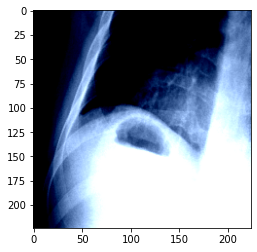

In [ ]:
inputs , classs = next(iter(trainloader))
x = inputs[0]
x = x.numpy().transpose((1, 2, 0))
plt.imshow(x)


In [ ]:
resnet18 = models.resnet18(pretrained=True)



resnet18.fc = nn.Sequential( nn.Linear( resnet18.fc.in_features , 10*10+100 , bias=True ), 
                             nn.ReLU( inplace=True ), 
                             nn.Dropout( p=0.5, inplace=False ), 
                             nn.Linear( 10*10+100 , 2 ) )

# UnFreeze all the layers except the last FC layers
for param in resnet18.parameters():
  param.requires_grad = True

for name, param in resnet18.named_parameters():
    if param.requires_grad:
        print(name)

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth



conv1.weight
bn1.weight
bn1.bias
layer1.0.conv1.weight
layer1.0.bn1.weight
layer1.0.bn1.bias
layer1.0.conv2.weight
layer1.0.bn2.weight
layer1.0.bn2.bias
layer1.1.conv1.weight
layer1.1.bn1.weight
layer1.1.bn1.bias
layer1.1.conv2.weight
layer1.1.bn2.weight
layer1.1.bn2.bias
layer2.0.conv1.weight
layer2.0.bn1.weight
layer2.0.bn1.bias
layer2.0.conv2.weight
layer2.0.bn2.weight
layer2.0.bn2.bias
layer2.0.downsample.0.weight
layer2.0.downsample.1.weight
layer2.0.downsample.1.bias
layer2.1.conv1.weight
layer2.1.bn1.weight
layer2.1.bn1.bias
layer2.1.conv2.weight
layer2.1.bn2.weight
layer2.1.bn2.bias
layer3.0.conv1.weight
layer3.0.bn1.weight
layer3.0.bn1.bias
layer3.0.conv2.weight
layer3.0.bn2.weight
layer3.0.bn2.bias
layer3.0.downsample.0.weight
layer3.0.downsample.1.weight
layer3.0.downsample.1.bias
layer3.1.conv1.weight
layer3.1.bn1.weight
layer3.1.bn1.bias
layer3.1.conv2.weight
layer3.1.bn2.weight
layer3.1.bn2.bias
layer4.0.conv1.weight
layer4.0.bn1.weight
layer4.0.bn1.bias
layer4.0.conv2.w

In [ ]:
def train_model(model, criterion, optimizer, num_epochs=10):
    start = time.time()

    trainErr = []
    trainAcc = []
    validErr = []
    validAcc = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0
            total = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs, labels = inputs.to(device), labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    inputs = inputs.to(device)
                    outputs = model(inputs)
                    _, preds = torch.max(outputs.data, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                total += labels.size(0)
                running_corrects += (preds == labels).sum().item()
            # if phase == 'train':
            #     scheduler.step()

            epoch_loss = running_loss / total
            epoch_acc  = running_corrects / total

            print('Epoch {}/{},{} ==> Loss: {:.4f} , Acc: {:.2f} %'.format(
                epoch+1, num_epochs,phase, epoch_loss, epoch_acc*100))
            
            
            if phase == 'train':
                trainErr.append(epoch_loss)
                trainAcc.append(epoch_acc*100)
            else:
                validErr.append(epoch_loss)
                validAcc.append(epoch_acc*100)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        print()

    endtime = time.time() - start
    print('Training complete in {:.0f}m {:.0f}s'.format( endtime // 60, endtime % 60))
    print('Best Validation Accuracy: {:4f} %'.format(best_acc*100))

    # load best model weights
    model.load_state_dict(best_model_wts)

    return model, trainErr, trainAcc, validErr, validAcc

In [ ]:
def testAccuracy(model,testloader):
  correct = 0
  total = 0
  with torch.no_grad():
      for data in testloader:
          images, labels = data
          images, labels = images.to(device), labels.to(device)
          outputs = model(images)
          _, predicted = torch.max(outputs.data, 1)
          total += labels.size(0)
          correct += (predicted == labels).sum().item()

  print('Accuracy of the network on  test data: %d %%' % (
      100 * correct / total))
def plotEvaluations(trainAcc,trainErr,validAcc,validErr):
  fig,ax = plt.subplots(2,2)
  fig.set_size_inches(10,5)

  ax[0][0].plot(trainAcc)
  ax[0][0].set_title('training Accuracy')
  ax[0][0].xaxis.set_visible(False) 


  ax[0][1].plot(trainErr)
  ax[0][1].set_title('training Loss')
  ax[0][1].xaxis.set_visible(False) 


  ax[1][0].plot(validAcc)
  ax[1][0].set_title('validation Accuracy')

  ax[1][1].plot(validErr)
  ax[1][1].set_title('validation Loss')


Epoch 1/10,train ==> Loss: 0.7103 , Acc: 51.00 %
Epoch 1/10,val ==> Loss: 0.6667 , Acc: 62.73 %

Epoch 2/10,train ==> Loss: 0.6837 , Acc: 55.83 %
Epoch 2/10,val ==> Loss: 0.6481 , Acc: 64.60 %

Epoch 3/10,train ==> Loss: 0.6701 , Acc: 58.54 %
Epoch 3/10,val ==> Loss: 0.6349 , Acc: 64.40 %

Epoch 4/10,train ==> Loss: 0.6605 , Acc: 59.92 %
Epoch 4/10,val ==> Loss: 0.6258 , Acc: 63.40 %

Epoch 5/10,train ==> Loss: 0.6514 , Acc: 61.56 %
Epoch 5/10,val ==> Loss: 0.6175 , Acc: 63.80 %

Epoch 6/10,train ==> Loss: 0.6449 , Acc: 62.62 %
Epoch 6/10,val ==> Loss: 0.6129 , Acc: 63.60 %

Epoch 7/10,train ==> Loss: 0.6375 , Acc: 63.41 %
Epoch 7/10,val ==> Loss: 0.6028 , Acc: 64.47 %

Epoch 8/10,train ==> Loss: 0.6279 , Acc: 64.66 %
Epoch 8/10,val ==> Loss: 0.6004 , Acc: 64.93 %

Epoch 9/10,train ==> Loss: 0.6244 , Acc: 65.18 %
Epoch 9/10,val ==> Loss: 0.5913 , Acc: 67.00 %

Epoch 10/10,train ==> Loss: 0.6177 , Acc: 65.78 %
Epoch 10/10,val ==> Loss: 0.5842 , Acc: 67.87 %

Training complete in 148m 41

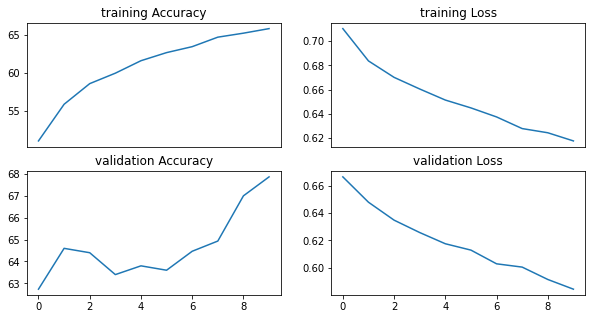

In [ ]:
Epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(resnet18.parameters(), lr=0.00001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    resnet18.cuda()
model, trainErr, trainAcc, validErr, validAcc = train_model( resnet18, criterion, optimizer, Epochs  )
torch.save(model, '/content/drive/My Drive/ResNet18_entire.pth')

testAccuracy(model,testloader)
plotEvaluations(trainAcc,trainErr,validAcc,validErr)



In [ ]:
def misClassification(actual,predict):
  infected_T = np.where( (actual==0) & (predict==0) )[0]
  infected_F = np.where( (actual==0) & (predict==1) )[0]
  normal_T   = np.where( (actual==1) & (predict==1) )[0]
  normal_F   = np.where( (actual==1) & (predict==0) )[0]
  print( len(infected_T), len(infected_F), len(normal_T), len(normal_F) )

  print('Actuall   = Infected')
  print('Actuall   =  Normal')

  plt.imshow(np.array(test_data[infected_F[0]][0]).transpose((1, 2, 0)))
  plt.title('Prediction = '+class_names[1])
  plt.show()


  print('Actuall   = Normal')
  print('Actuall   = Infected')

  plt.imshow(np.array(test_data[normal_F[0]][0]).transpose((1, 2, 0)))
  plt.title('Prediction = '+class_names[0])
  plt.show()



def calculateF1(y_true,y_pred):
  tp = (y_true * y_pred).sum()
  tn = ((1 - y_true) * (1 - y_pred)).sum()
  fp = ((1 - y_true) * y_pred).sum()
  fn = (y_true * (1 - y_pred)).sum()
  epsilon = 1e-7

  precision = tp / (tp + fp + epsilon)
  recall = tp / (tp + fn + epsilon)
  f1 = 2* (precision*recall) / (precision + recall + epsilon)

  print("\n precision = ",precision, "\n Recall    = ", recall, "\n F1 score = ", f1)

def confusion_mat(model,testloader ):

  classes = 2
  actual  = []
  predict = []

  confusion_matrix = torch.zeros(classes, classes)
  with torch.no_grad():
      for i, (inputs, classes) in enumerate(testloader):
          inputs  = inputs.to(device)
          classes = classes.to(device)
          outputs = model(inputs)
          _,preds = torch.max(outputs, 1)
          for t, p in zip(classes.view(-1), preds.view(-1)):
                  confusion_matrix[t.long(), p.long()] += 1
          actual.extend( np.array(classes.cpu()) )
          predict.extend(np.array(preds.cpu()) )
      actual  = np.array(actual)
      predict = np.array(predict)
      misClassification(actual,predict)
      calculateF1(actual,predict)
  return confusion_matrix

def plot_confusion_matrix(cm, classes):
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix')
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' 
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


172 443 877 8
Actuall   = Infected
Actuall   =  Normal


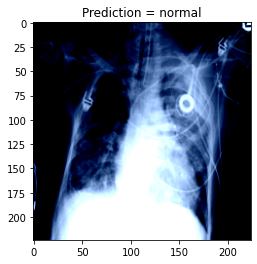

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Actuall   = Normal
Actuall   = Infected


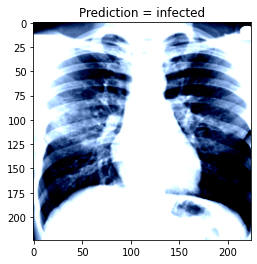


 precision =  0.6643939393436065 
 Recall    =  0.9909604518654282 
 F1 score =  0.7954648044815101


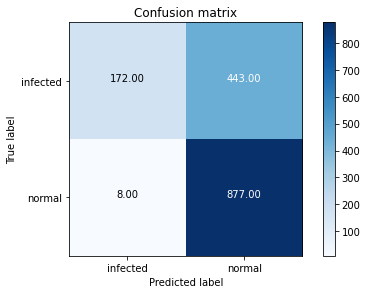

In [ ]:
path  = '/content/drive/My Drive/ResNet18_entire.pth'
model = loadTrainedModel(path)

classes = ['infected', 'normal']
cm = confusion_mat(model,testloader)

plot_confusion_matrix(cm, classes)
